In [3]:
import sys
sys.path.insert(0, '/Users/ahmedbegga/Desktop/TFG-Ahmed/SetXAI/src')
import torch
import torch.nn as nn
import torch.nn.functional as F
from utils import chamfer_loss
from utils import hungarian_loss
from fspool import FSPool
from model import FSEncoder
from dspn import *
from model import FSEncoderClasification
from MnistSet import MNISTSet
from MnistSet import get_loader

In [4]:
train_loader = get_loader(
            MNISTSet(train=True, full=True), batch_size=1, num_workers=2
        )

0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz


0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz


0it [00:00, ?it/s]

Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
Procesando el dataset...


/Users/ahmedbegga/miniforge3/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/datasets/mnist.py:335: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1635217280611/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed).view(length, num_rows, num_cols)


Listo!


In [5]:
test_loader = get_loader(
            MNISTSet(train=False, full=True), batch_size=1, num_workers=2
        )

Procesando el dataset...
Listo!


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import torchvision
import matplotlib.pyplot as plt
import numpy as np



def build_net():
    set_channels = 2
    set_size = 342
    hidden_dim = 256
    inner_lr = 800
    iters = 10
    latent_dim = 64
    input_encoder = None

    set_encoder = FSEncoder(set_channels, latent_dim, hidden_dim)
    set_decoder = DSPN(set_encoder, set_channels, set_size, hidden_dim, iters, inner_lr)
    net = Net(
        input_encoder=input_encoder, set_encoder=set_encoder, set_decoder=set_decoder
    )
    return net


class Net(nn.Module):
    def __init__(self, set_encoder, set_decoder, input_encoder=None):
        """
        In the auto-encoder setting, don't pass an input_encoder because the target set and mask is
        assumed to be the input.
        In the general prediction setting, must pass all three.
        """
        super().__init__()
        self.set_encoder = set_encoder
        self.input_encoder = input_encoder
        self.set_decoder = set_decoder

        for m in self.modules():
            if (
                isinstance(m, nn.Linear)
                or isinstance(m, nn.Conv2d)
                or isinstance(m, nn.Conv1d)
            ):
                init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input, target_set, target_mask):
        if self.input_encoder is None:
            # auto-encoder, ignore input and use target set and mask as input instead
            latent_repr = self.set_encoder(target_set, target_mask)
            target_repr = latent_repr
        else:
            # set prediction, use proper input_encoder
            latent_repr = self.input_encoder(input)
            # note that target repr is only used for loss computation in training
            # during inference, knowledge about the target is not needed
            target_repr = self.set_encoder(target_set, target_mask)

        predicted_set = self.set_decoder(latent_repr)

        return predicted_set, (target_repr, latent_repr)

In [7]:
net = build_net()

In [8]:
net

Net(
  (set_encoder): FSEncoder(
    (conv): Sequential(
      (0): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
      (1): ReLU()
      (2): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
      (3): ReLU()
      (4): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
    )
    (pool): FSPool()
  )
  (set_decoder): DSPN(
    (encoder): FSEncoder(
      (conv): Sequential(
        (0): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
        (1): ReLU()
        (2): Conv1d(256, 256, kernel_size=(1,), stride=(1,))
        (3): ReLU()
        (4): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
      )
      (pool): FSPool()
    )
  )
)

In [9]:
optimizer = torch.optim.Adam(
    [p for p in net.parameters() if p.requires_grad], lr=0.01
)

In [10]:
import seaborn as sn
import matplotlib
import matplotlib.pyplot as pyplot
import numpy as np

### Usando chamfer loss

In [11]:
dataset = MNISTSet(train=False, full=True)
expected, sample,mask_sample = dataset[13]
sample = sample.unsqueeze(0)
mask_sample = mask_sample.unsqueeze(0)
expected = torch.tensor(expected).unsqueeze(0)

In [16]:
expected.shape

torch.Size([1])

In [17]:
sample.shape
sample.dtype

torch.float32

In [18]:
mask_sample.shape
sample.dtype

torch.float32

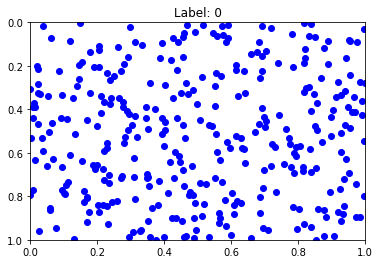

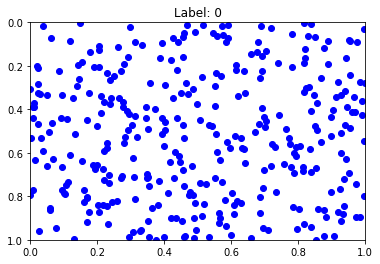

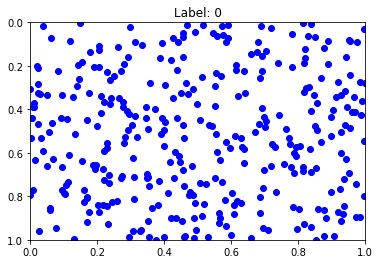

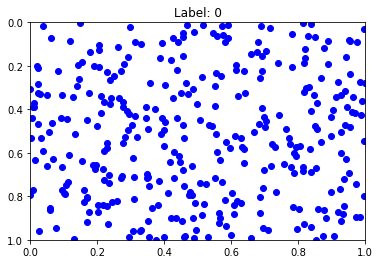

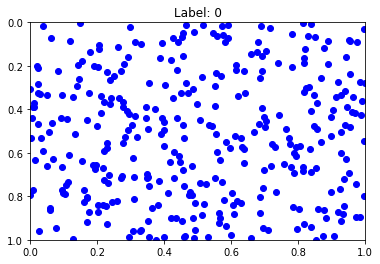

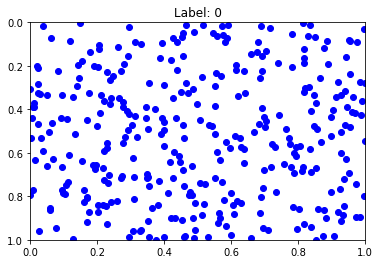

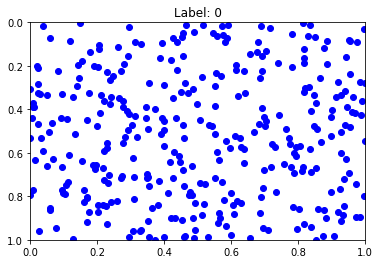

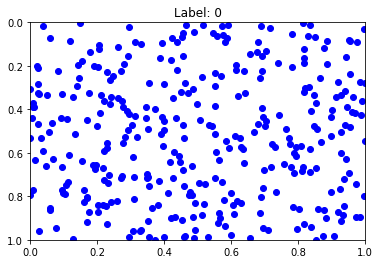

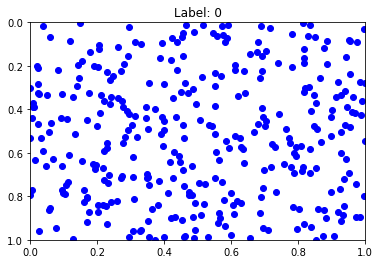

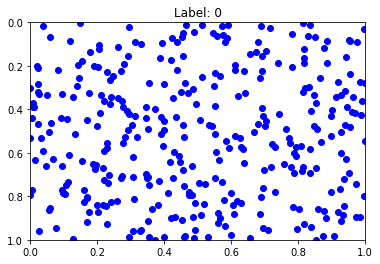

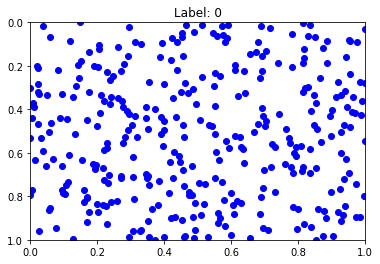

tensor([0.0866, 0.0866, 0.0866, 0.0866, 0.0866, 0.0866, 0.0866, 0.0865, 0.0865,
        0.0865, 0.0865], grad_fn=<MeanBackward1>)
tensor([0])
tensor([0.0828, 0.0824, 0.0819, 0.0814, 0.0809, 0.0804, 0.0800, 0.0795, 0.0790,
        0.0786, 0.0781], grad_fn=<MeanBackward1>)
tensor([0.0792, 0.0758, 0.0726, 0.0697, 0.0668, 0.0643, 0.0619, 0.0597, 0.0575,
        0.0556, 0.0538], grad_fn=<MeanBackward1>)
tensor([0.0759, 0.0640, 0.0547, 0.0475, 0.0414, 0.0366, 0.0331, 0.0305, 0.0287,
        0.0273, 0.0263], grad_fn=<MeanBackward1>)
tensor([0.0728, 0.0424, 0.0292, 0.0238, 0.0224, 0.0223, 0.0225, 0.0229, 0.0236,
        0.0241, 0.0246], grad_fn=<MeanBackward1>)
tensor([0.0700, 0.0266, 0.0210, 0.0207, 0.0214, 0.0223, 0.0233, 0.0242, 0.0248,
        0.0259, 0.0263], grad_fn=<MeanBackward1>)
tensor([0.0674, 0.0208, 0.0212, 0.0224, 0.0237, 0.0248, 0.0261, 0.0277, 0.0282,
        0.0294, 0.0294], grad_fn=<MeanBackward1>)
tensor([0.0650, 0.0154, 0.0199, 0.0206, 0.0219, 0.0227, 0.0238, 0.0247, 0.0258

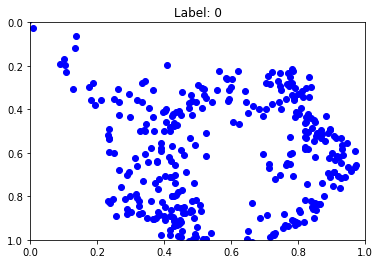

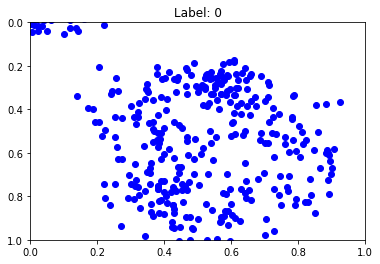

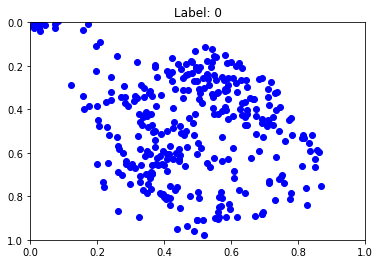

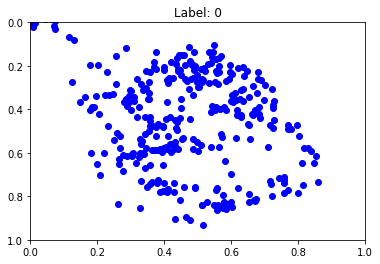

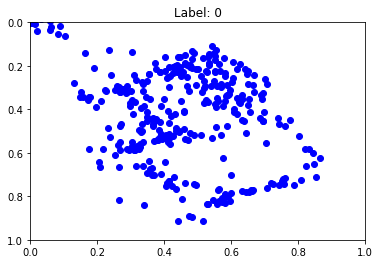

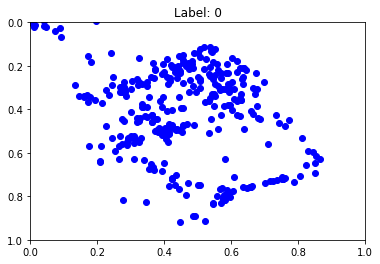

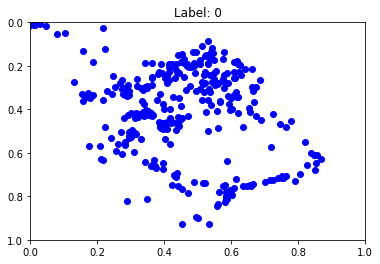

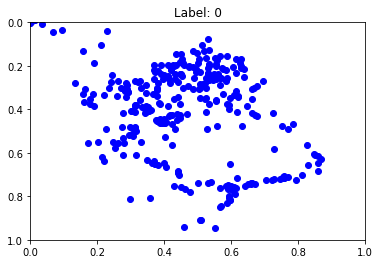

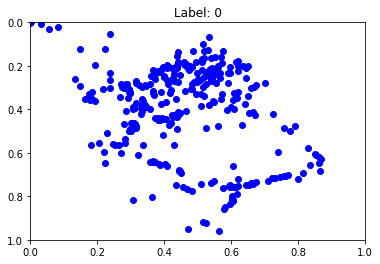

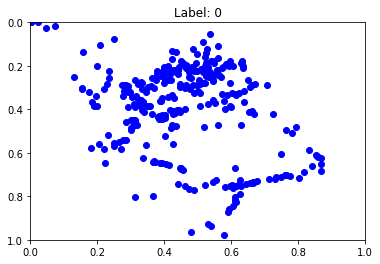

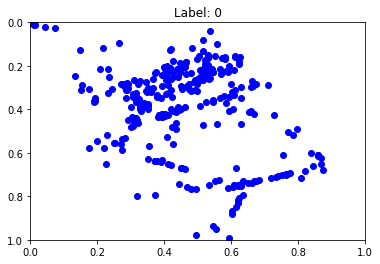

tensor([0.0379, 0.0053, 0.0033, 0.0022, 0.0016, 0.0013, 0.0011, 0.0011, 0.0010,
        0.0010, 0.0010], grad_fn=<MeanBackward1>)
tensor([0.0370, 0.0055, 0.0034, 0.0023, 0.0018, 0.0014, 0.0013, 0.0012, 0.0011,
        0.0010, 0.0011], grad_fn=<MeanBackward1>)
tensor([0.0360, 0.0056, 0.0032, 0.0020, 0.0015, 0.0012, 0.0011, 0.0011, 0.0010,
        0.0010, 0.0010], grad_fn=<MeanBackward1>)
tensor([0.0352, 0.0045, 0.0026, 0.0017, 0.0012, 0.0010, 0.0009, 0.0009, 0.0008,
        0.0008, 0.0008], grad_fn=<MeanBackward1>)
tensor([0.0343, 0.0039, 0.0022, 0.0015, 0.0011, 0.0009, 0.0008, 0.0008, 0.0008,
        0.0008, 0.0008], grad_fn=<MeanBackward1>)
tensor([0.0335, 0.0039, 0.0022, 0.0015, 0.0011, 0.0009, 0.0008, 0.0007, 0.0007,
        0.0007, 0.0007], grad_fn=<MeanBackward1>)
tensor([0.0327, 0.0036, 0.0021, 0.0013, 0.0009, 0.0007, 0.0006, 0.0006, 0.0005,
        0.0005, 0.0005], grad_fn=<MeanBackward1>)
tensor([0.0320, 0.0034, 0.0018, 0.0011, 0.0008, 0.0006, 0.0005, 0.0005, 0.0005,
        0.

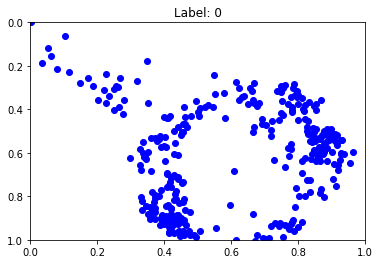

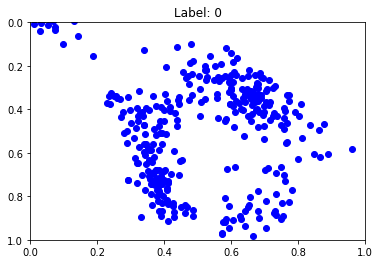

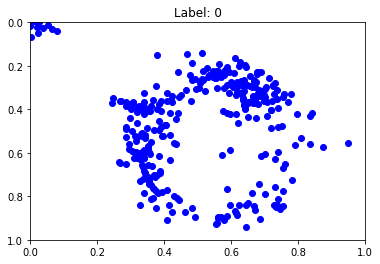

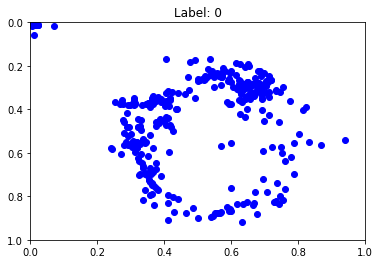

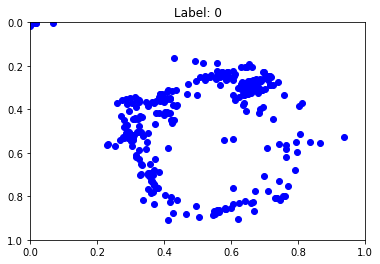

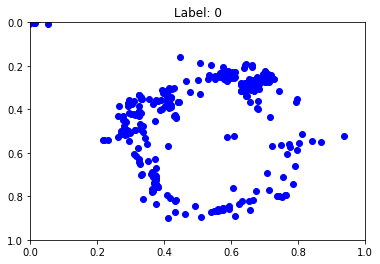

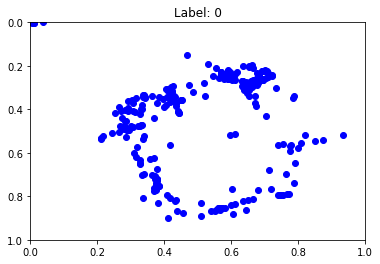

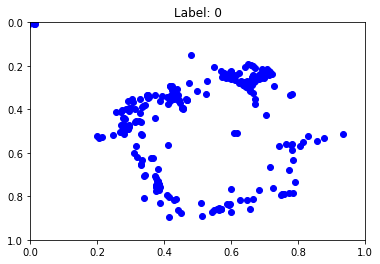

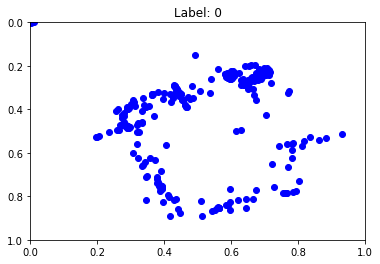

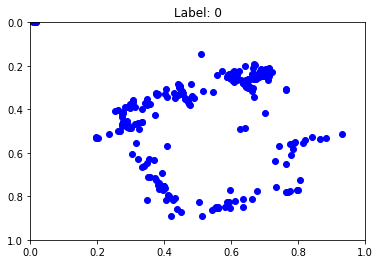

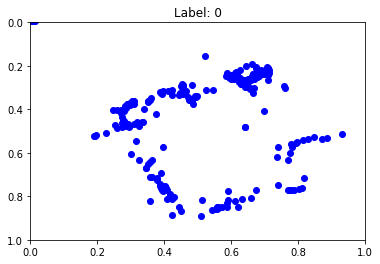

tensor([0.0229, 0.0011, 0.0005, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002], grad_fn=<MeanBackward1>)
tensor([0.0225, 0.0010, 0.0005, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002], grad_fn=<MeanBackward1>)
tensor([0.0222, 0.0009, 0.0005, 0.0003, 0.0003, 0.0003, 0.0003, 0.0002, 0.0002,
        0.0003, 0.0003], grad_fn=<MeanBackward1>)
tensor([0.0218, 0.0009, 0.0005, 0.0003, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0003, 0.0003], grad_fn=<MeanBackward1>)
tensor([0.0215, 0.0011, 0.0005, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0003], grad_fn=<MeanBackward1>)
tensor([0.0212, 0.0010, 0.0005, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004, 0.0004,
        0.0004, 0.0004], grad_fn=<MeanBackward1>)
tensor([0.0209, 0.0009, 0.0005, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0004], grad_fn=<MeanBackward1>)
tensor([0.0206, 0.0009, 0.0004, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.

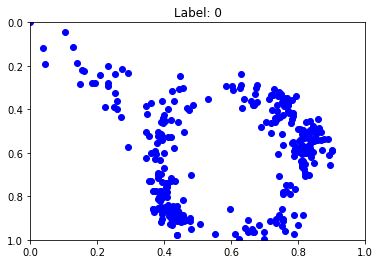

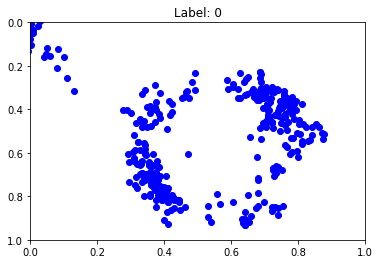

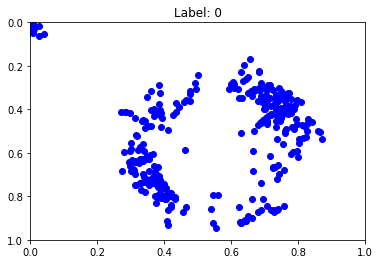

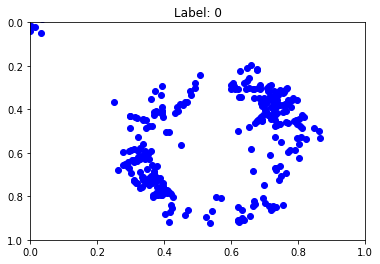

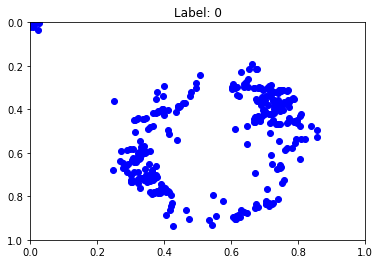

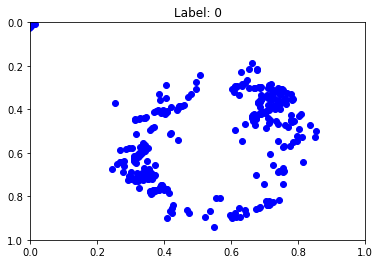

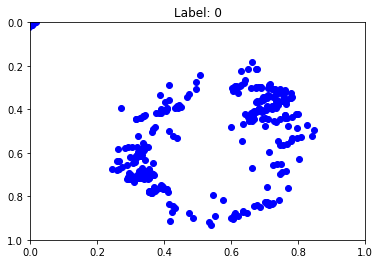

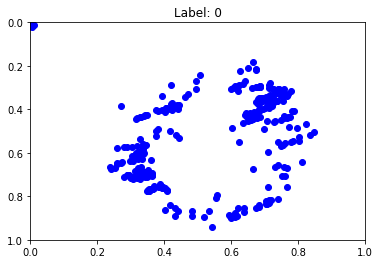

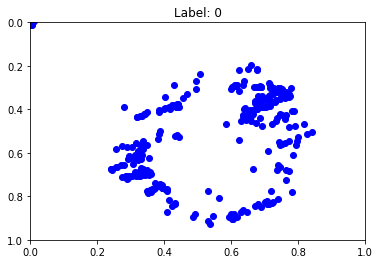

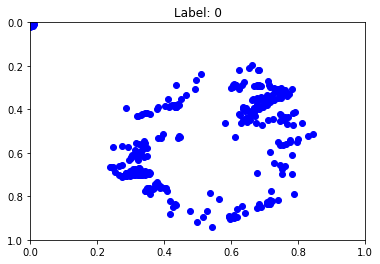

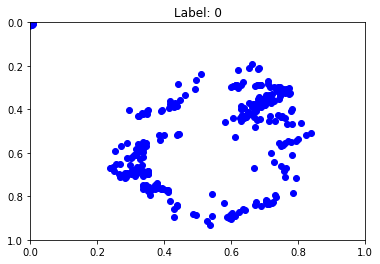

tensor([0.0112, 0.0011, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002], grad_fn=<MeanBackward1>)
tensor([0.0110, 0.0009, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002], grad_fn=<MeanBackward1>)
tensor([0.0109, 0.0010, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0003, 0.0003,
        0.0003, 0.0004], grad_fn=<MeanBackward1>)
tensor([0.0107, 0.0010, 0.0002, 0.0001, 0.0001, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002], grad_fn=<MeanBackward1>)
tensor([0.0106, 0.0011, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002], grad_fn=<MeanBackward1>)
tensor([0.0104, 0.0013, 0.0004, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002], grad_fn=<MeanBackward1>)
tensor([0.0102, 0.0012, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002], grad_fn=<MeanBackward1>)
tensor([0.0101, 0.0010, 0.0003, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.0002,
        0.

tensor([0.0045, 0.0005, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001], grad_fn=<MeanBackward1>)
tensor([0.0045, 0.0005, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0001, 0.0001], grad_fn=<MeanBackward1>)
tensor([0.0044, 0.0005, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001,
        0.0002, 0.0002], grad_fn=<MeanBackward1>)
tensor([4.3184e-03, 4.8059e-04, 1.1702e-04, 8.4708e-05, 8.7048e-05, 8.9751e-05,
        9.3502e-05, 1.0025e-04, 1.0304e-04, 1.1396e-04, 1.1610e-04],
       grad_fn=<MeanBackward1>)
tensor([4.2500e-03, 6.6845e-04, 1.4630e-04, 1.0141e-04, 9.8500e-05, 1.0991e-04,
        1.3406e-04, 1.4830e-04, 1.7037e-04, 1.9457e-04, 2.1596e-04],
       grad_fn=<MeanBackward1>)
tensor([4.1816e-03, 7.3251e-04, 1.4319e-04, 8.6096e-05, 8.4277e-05, 8.9026e-05,
        8.8521e-05, 9.4532e-05, 1.0286e-04, 1.0958e-04, 1.1784e-04],
       grad_fn=<MeanBackward1>)
tensor([0.0041, 0.0010, 0.0002, 0.0001, 0.0001, 0.0001, 0.0001, 0.0

tensor([0.0019, 0.0004, 0.0003, 0.0003, 0.0004, 0.0005, 0.0006, 0.0008, 0.0009,
        0.0008, 0.0009], grad_fn=<MeanBackward1>)
tensor([0.0019, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0004, 0.0004], grad_fn=<MeanBackward1>)
tensor([0.0019, 0.0005, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003, 0.0004,
        0.0004, 0.0005], grad_fn=<MeanBackward1>)
tensor([0.0019, 0.0006, 0.0004, 0.0004, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003,
        0.0003, 0.0004], grad_fn=<MeanBackward1>)
tensor([0.0018, 0.0005, 0.0004, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0002], grad_fn=<MeanBackward1>)
tensor([0.0018, 0.0005, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.0002, 0.0003], grad_fn=<MeanBackward1>)
tensor([0.0018, 0.0004, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0003,
        0.0003, 0.0003], grad_fn=<MeanBackward1>)
tensor([0.0018, 0.0004, 0.0003, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002, 0.0002,
        0.

tensor([7.0869e-04, 8.7986e-05, 4.6144e-05, 3.7671e-05, 3.5596e-05, 3.6435e-05,
        3.8698e-05, 4.1110e-05, 4.1889e-05, 4.3781e-05, 4.5863e-05],
       grad_fn=<MeanBackward1>)
tensor([6.9963e-04, 8.8546e-05, 4.5243e-05, 3.7451e-05, 3.5409e-05, 3.5732e-05,
        3.4167e-05, 3.4690e-05, 3.7207e-05, 4.0480e-05, 4.4360e-05],
       grad_fn=<MeanBackward1>)
tensor([6.9089e-04, 9.0136e-05, 4.5712e-05, 3.8274e-05, 3.4245e-05, 3.2965e-05,
        3.4009e-05, 3.5845e-05, 3.9434e-05, 4.4124e-05, 5.0261e-05],
       grad_fn=<MeanBackward1>)
tensor([6.8137e-04, 8.9187e-05, 4.7138e-05, 4.0077e-05, 3.6882e-05, 3.5453e-05,
        3.6614e-05, 3.9517e-05, 4.3800e-05, 4.9265e-05, 5.6054e-05],
       grad_fn=<MeanBackward1>)
tensor([6.7093e-04, 8.1221e-05, 4.3758e-05, 3.6776e-05, 3.4347e-05, 3.3176e-05,
        3.3399e-05, 3.4543e-05, 3.6565e-05, 3.8541e-05, 4.1950e-05],
       grad_fn=<MeanBackward1>)
tensor([6.6005e-04, 7.3057e-05, 4.0963e-05, 3.4773e-05, 3.2404e-05, 3.1942e-05,
        3.2345e

tensor([3.9440e-04, 3.0735e-05, 1.6537e-05, 1.2765e-05, 1.1242e-05, 1.0396e-05,
        1.0100e-05, 1.0322e-05, 1.0698e-05, 1.1482e-05, 1.2318e-05],
       grad_fn=<MeanBackward1>)
tensor([3.8968e-04, 2.5453e-05, 1.3465e-05, 1.0946e-05, 9.5072e-06, 9.1633e-06,
        9.2927e-06, 1.0089e-05, 1.0918e-05, 1.2340e-05, 1.3650e-05],
       grad_fn=<MeanBackward1>)
tensor([3.8399e-04, 2.8925e-05, 1.2334e-05, 1.0306e-05, 9.3258e-06, 9.4001e-06,
        1.0041e-05, 1.1271e-05, 1.2750e-05, 1.4787e-05, 1.6586e-05],
       grad_fn=<MeanBackward1>)
tensor([3.7889e-04, 2.3781e-05, 1.2715e-05, 1.0673e-05, 9.9434e-06, 1.0080e-05,
        1.0573e-05, 1.1613e-05, 1.2756e-05, 1.4164e-05, 1.5939e-05],
       grad_fn=<MeanBackward1>)
tensor([3.7466e-04, 2.4669e-05, 1.3569e-05, 1.1053e-05, 9.7951e-06, 9.4564e-06,
        9.3536e-06, 9.9367e-06, 1.0535e-05, 1.1436e-05, 1.2634e-05],
       grad_fn=<MeanBackward1>)
tensor([3.7031e-04, 3.0362e-05, 1.4990e-05, 1.2187e-05, 1.1185e-05, 1.0821e-05,
        1.0338e

tensor([2.3854e-04, 1.4622e-05, 6.4197e-06, 5.7052e-06, 5.0527e-06, 5.1384e-06,
        5.0821e-06, 5.3582e-06, 5.5800e-06, 6.0865e-06, 6.3284e-06],
       grad_fn=<MeanBackward1>)
tensor([2.3622e-04, 1.4889e-05, 6.6145e-06, 5.7623e-06, 5.1476e-06, 4.9416e-06,
        5.0152e-06, 5.2847e-06, 5.4977e-06, 6.0058e-06, 6.3561e-06],
       grad_fn=<MeanBackward1>)
tensor([2.3406e-04, 1.4642e-05, 6.5403e-06, 5.6827e-06, 5.2453e-06, 4.9528e-06,
        5.0869e-06, 5.2692e-06, 5.5379e-06, 6.0724e-06, 6.4749e-06],
       grad_fn=<MeanBackward1>)
tensor([2.3163e-04, 1.3759e-05, 6.4554e-06, 5.4620e-06, 5.0275e-06, 4.9171e-06,
        5.0722e-06, 5.3445e-06, 5.7733e-06, 6.2437e-06, 6.6985e-06],
       grad_fn=<MeanBackward1>)
tensor([2.2925e-04, 1.3351e-05, 6.6922e-06, 5.5202e-06, 5.1184e-06, 5.0926e-06,
        5.1811e-06, 5.4963e-06, 5.7440e-06, 6.1943e-06, 6.6795e-06],
       grad_fn=<MeanBackward1>)
tensor([2.2720e-04, 1.3800e-05, 6.8239e-06, 5.6426e-06, 5.2769e-06, 5.1078e-06,
        5.2650e

tensor([1.5800e-04, 1.5794e-05, 5.8967e-06, 4.8387e-06, 4.4849e-06, 4.4058e-06,
        4.4953e-06, 4.7192e-06, 5.0106e-06, 5.4199e-06, 5.8445e-06],
       grad_fn=<MeanBackward1>)
tensor([1.5668e-04, 1.4987e-05, 5.8082e-06, 4.8284e-06, 4.4611e-06, 4.3769e-06,
        4.4739e-06, 4.6977e-06, 4.9297e-06, 5.3388e-06, 5.8187e-06],
       grad_fn=<MeanBackward1>)
tensor([1.5540e-04, 1.4670e-05, 5.9183e-06, 4.8416e-06, 4.5214e-06, 4.4187e-06,
        4.5166e-06, 4.7106e-06, 5.0116e-06, 5.3655e-06, 5.8295e-06],
       grad_fn=<MeanBackward1>)
tensor([1.5415e-04, 1.4682e-05, 5.9642e-06, 4.8573e-06, 4.5179e-06, 4.4213e-06,
        4.5392e-06, 4.7221e-06, 4.8809e-06, 5.1823e-06, 5.6127e-06],
       grad_fn=<MeanBackward1>)
tensor([1.5289e-04, 1.4407e-05, 5.9656e-06, 4.9322e-06, 4.5275e-06, 4.4364e-06,
        4.4581e-06, 4.6318e-06, 4.9157e-06, 5.2194e-06, 5.6293e-06],
       grad_fn=<MeanBackward1>)
tensor([1.5164e-04, 1.3672e-05, 5.8981e-06, 4.8440e-06, 4.4780e-06, 4.4606e-06,
        4.5276e

tensor([1.0882e-04, 1.4133e-05, 6.9428e-06, 5.7432e-06, 5.3218e-06, 5.2335e-06,
        5.1671e-06, 5.3264e-06, 5.4745e-06, 5.8760e-06, 6.2190e-06],
       grad_fn=<MeanBackward1>)
tensor([1.0804e-04, 1.3711e-05, 6.6413e-06, 5.5627e-06, 5.0884e-06, 5.0516e-06,
        4.9695e-06, 5.1852e-06, 5.3508e-06, 5.7641e-06, 6.1059e-06],
       grad_fn=<MeanBackward1>)
tensor([1.0702e-04, 1.3543e-05, 6.4167e-06, 5.4795e-06, 5.0179e-06, 5.0687e-06,
        4.9537e-06, 5.2124e-06, 5.3386e-06, 5.7659e-06, 6.0542e-06],
       grad_fn=<MeanBackward1>)
tensor([1.0576e-04, 1.3937e-05, 6.0467e-06, 5.2262e-06, 4.8212e-06, 4.9380e-06,
        4.9422e-06, 5.2832e-06, 5.4714e-06, 6.0102e-06, 6.3867e-06],
       grad_fn=<MeanBackward1>)
tensor([1.0489e-04, 1.3418e-05, 6.1716e-06, 5.1688e-06, 4.9273e-06, 4.9222e-06,
        5.0739e-06, 5.3515e-06, 5.6780e-06, 6.1569e-06, 6.6442e-06],
       grad_fn=<MeanBackward1>)
tensor([1.0429e-04, 1.3494e-05, 6.4280e-06, 5.2504e-06, 4.9174e-06, 4.7458e-06,
        4.7802e

In [82]:
for i in range(500):
    input, target_set, target_mask = expected,sample,mask_sample
    if(i == 1):
        print(input)
    (progress, masks, evals, gradn), (y_enc, y_label) = net(input, target_set, target_mask)
    if i == 0 or  i == 25 or i ==  50 or i == 99:
    #plt.grid(False)
    #plt.tight_layout()
    #print(len(progress))
        for  a in progress:
            sam = a[0].detach().numpy()
            x = sam[1, :]
            y = sam[0, :]
            pyplot.scatter(x, y,color ='b')
            #plt.axes().set_aspect("equal")
            plt.axis([0, 1, 1, 0])
            plt.title('Label: {}'.format(input[0]))
            #plt.savefig('test.png')
            plt.show()
            progress_only = progress

  # if using mask as feature, concat mask feature into progress
    target_set = torch.cat(
      [target_set, target_mask.unsqueeze(dim=1)], dim=1)
    progress = [
      torch.cat([p, m.unsqueeze(dim=1)], dim=1)
      for p, m in zip(progress, masks)
            ]
  # dim 0 is over the inner iteration steps
  # target set is broadcasted over dim 0
    set_loss = chamfer_loss(
      torch.stack(progress), target_set.unsqueeze(0)
    )
    loss = set_loss.mean()
    print(set_loss)
    #print(loss)
    progress = progress_only

    #print("New progress",len(progress))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [83]:
#with torch.no_grad():
(progress, masks, evals, gradn), (y_enc, y_label) = net(input,sample,mask_sample)

In [84]:
progress[0].shape
sam = progress[10].squeeze(0).detach().numpy()

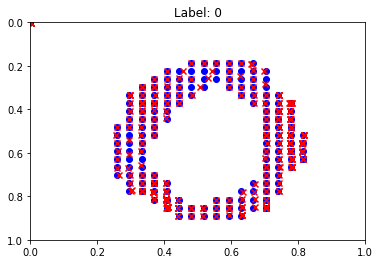

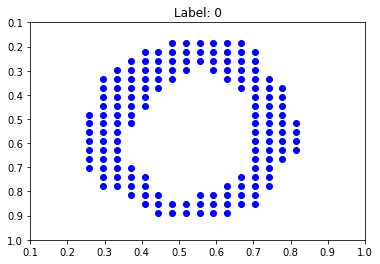

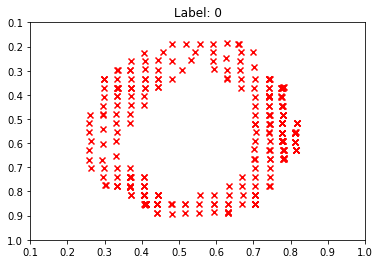

torch.Tensor

In [85]:
dataset = MNISTSet(train=False, full=True)
expected, sample,mask_sample = dataset[13]
x = sample[1, :]
y = sample[0, :]
pyplot.scatter(x, y,color ='b')

x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,marker = 'x',color ='r')

pyplot.axis([0, 1, 1, 0])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

x = sample[1, :]
y = sample[0, :]
pyplot.scatter(x, y,color ='b')
pyplot.axis([0.1, 1, 1, 0.1])
pyplot.title('Label: {}'.format(expected))

pyplot.show()
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,marker = 'x',color ='r')
pyplot.axis([0.1, 1, 1, 0.1])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

sample = sample.unsqueeze(0)
mask_sample = mask_sample.unsqueeze(0)
expected = torch.tensor(expected).unsqueeze(0)
type(sample)

### Usando Hungarian

In [109]:
netHungarian = build_net()
optimizer = torch.optim.Adam(
    [p for p in netHungarian.parameters() if p.requires_grad], lr=0.03
)

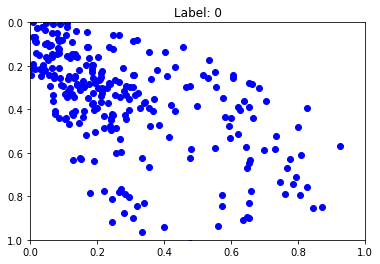

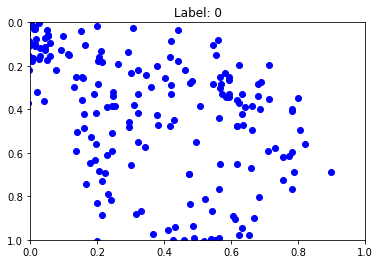

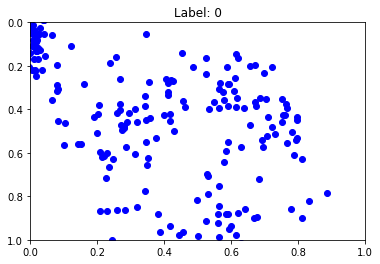

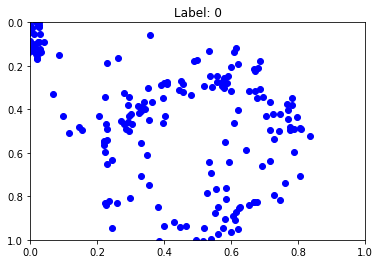

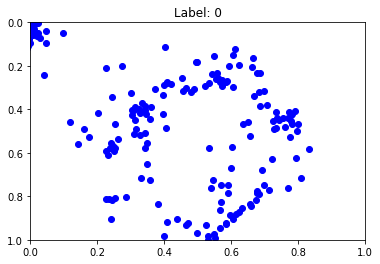

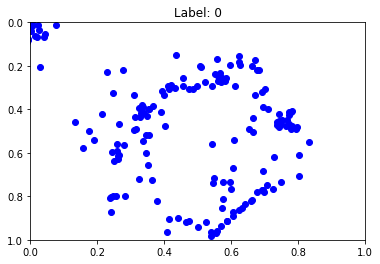

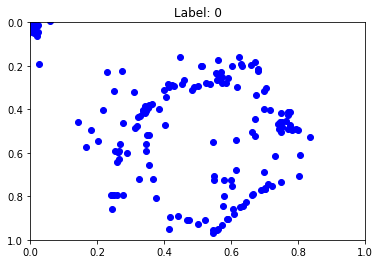

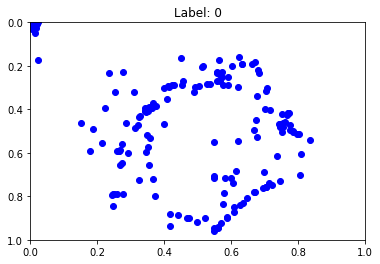

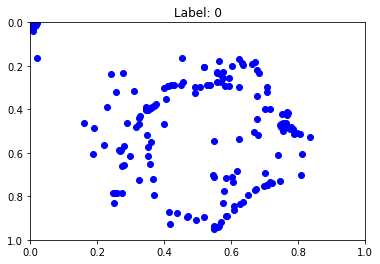

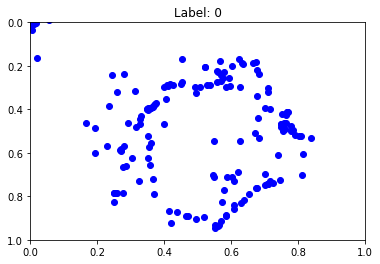

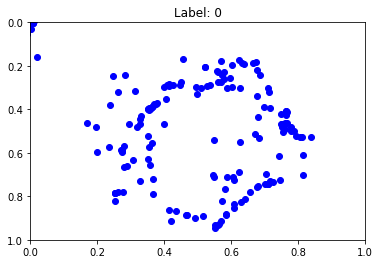

tensor(0.0006, grad_fn=<MeanBackward0>)
tensor([0])
tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<Mean

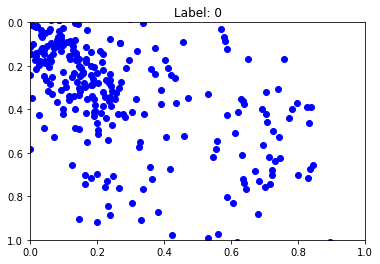

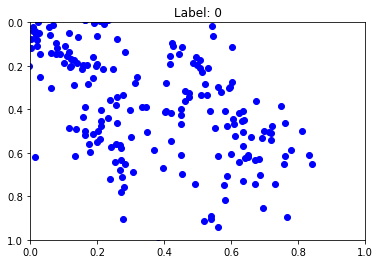

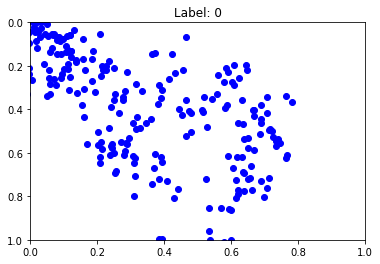

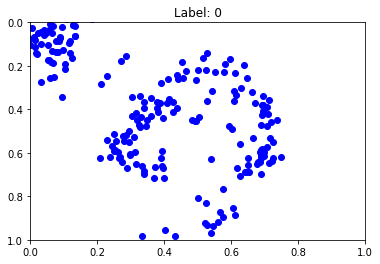

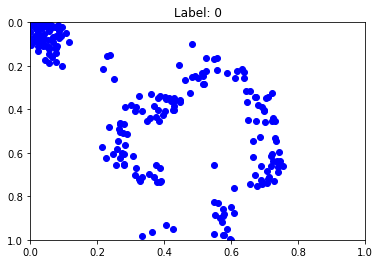

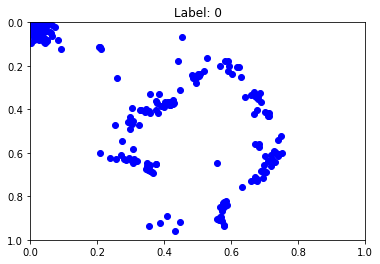

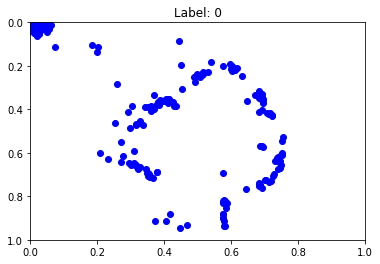

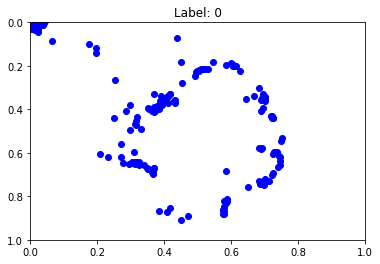

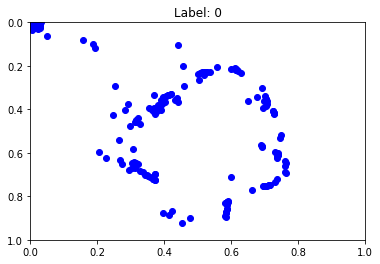

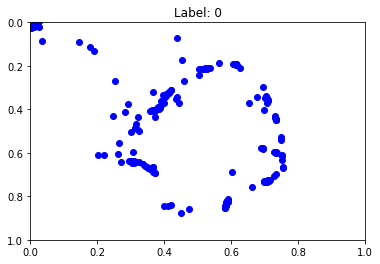

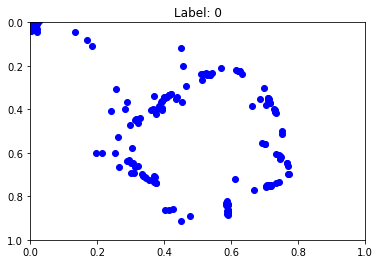

tensor(0.0008, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0005, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0004, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)


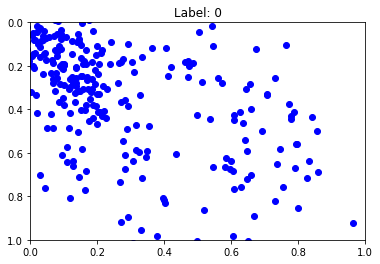

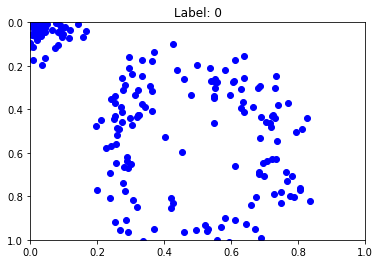

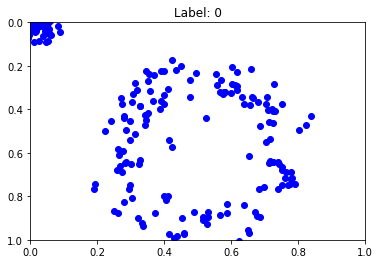

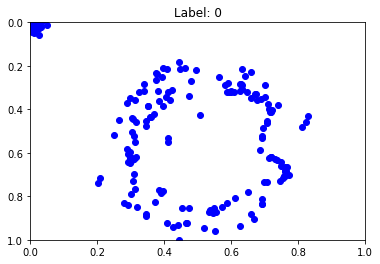

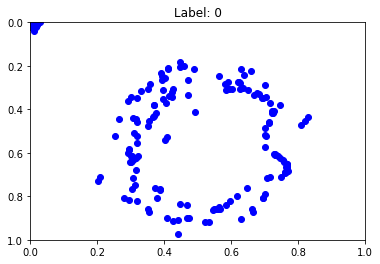

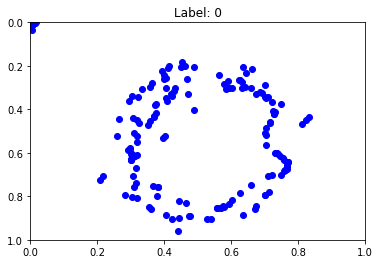

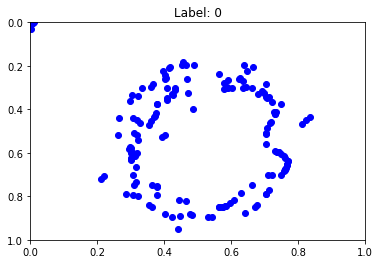

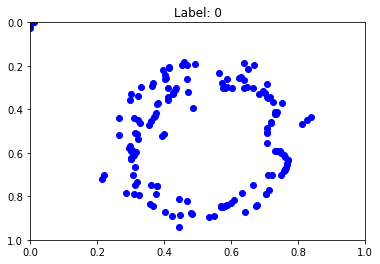

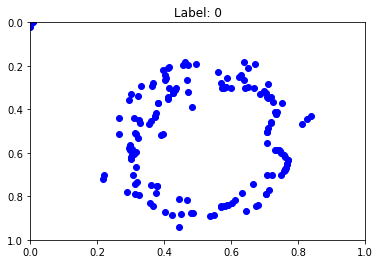

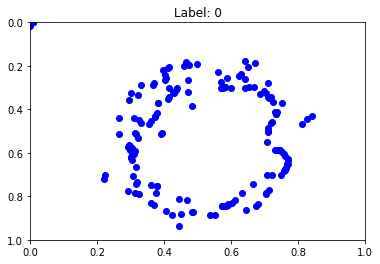

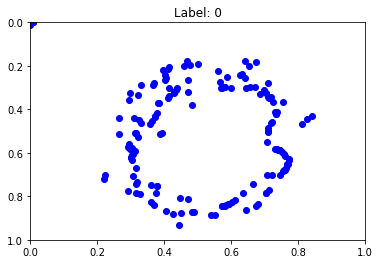

tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0003, grad_fn=<MeanBackward0>)
tensor(0.0002, grad_fn=<MeanBackward0>)


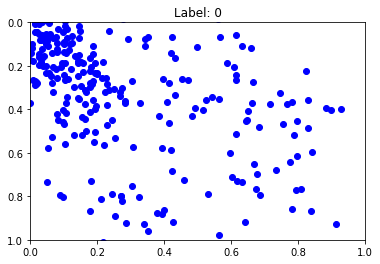

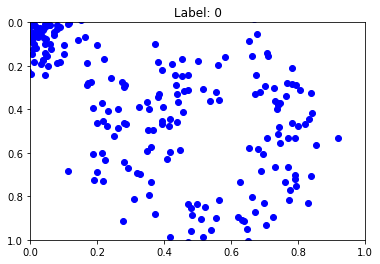

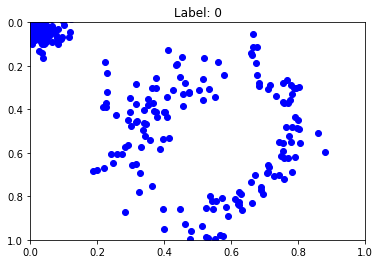

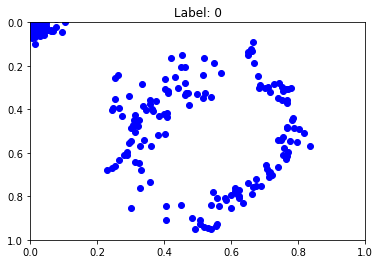

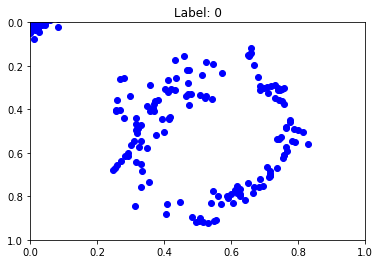

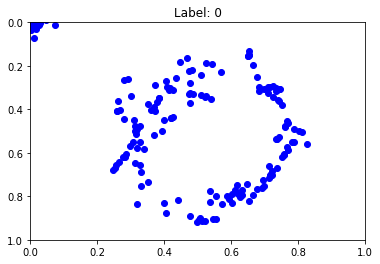

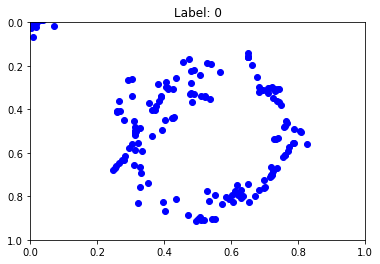

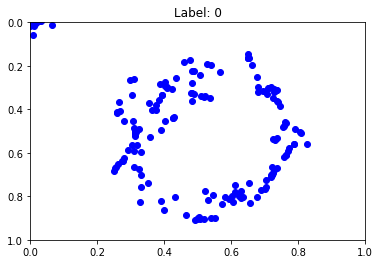

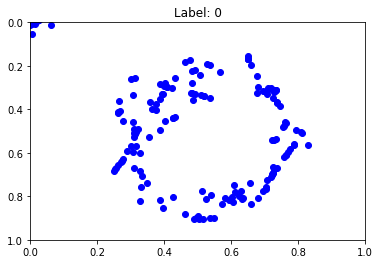

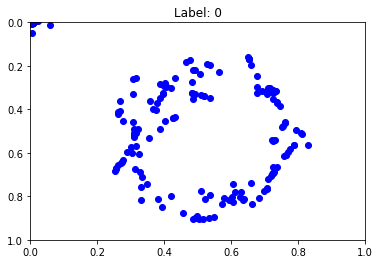

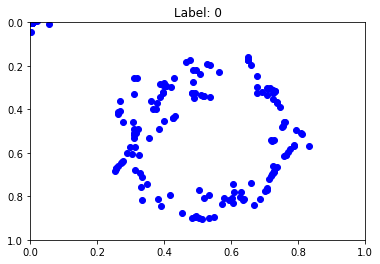

tensor(0.0003, grad_fn=<MeanBackward0>)


In [118]:
for i in range(100):
    #input, target_set, target_mask = map(lambda x: x, sample)
    if(i == 1):
        print(input)
    input, target_set, target_mask = expected,sample,mask_sample
    (progress, masks, evals, gradn), (y_enc, y_label) = netHungarian(input, target_set, target_mask)
    if i == 0 or  i == 25 or i ==  50 or i == 99:
    #plt.grid(False)
    #plt.tight_layout()
    #print(len(progress))
        for  a in progress:
          #print(a.shape)
            #a = a.cpu().data.numpy()
            sam = a[0].detach().numpy()
            x = sam[1, :]
            y = sam[0, :]
            pyplot.scatter(x, y,color ='b')
            plt.axis([0, 1, 1, 0])
            plt.title('Label: {}'.format(input[0]))
            #plt.savefig('test.png')
            plt.show()
            progress_only = progress

  # if using mask as feature, concat mask feature into progress
    target_set = torch.cat(
      [target_set, target_mask.unsqueeze(dim=1)], dim=1)
    progress = [
      torch.cat([p, m.unsqueeze(dim=1)], dim=1)
      for p, m in zip(progress, masks)
            ]
  # dim 0 is over the inner iteration steps
  # target set is broadcasted over dim 0
    a = torch.stack(progress)
  # target set is explicitly broadcasted over dim 0
    b = target_set.repeat(a.size(0), 1, 1, 1)
  # flatten inner iteration dim and batch dim
    a = a.view(-1, a.size(2), a.size(3))
    b = b.view(-1, b.size(2), b.size(3))
    set_loss = hungarian_loss(
      progress[-1], target_set
    ).unsqueeze(0)
    loss = set_loss.mean()
    #print(set_loss)
    print(loss)
    progress = progress_only

    #print("New progress",len(progress))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


In [119]:
#with torch.no_grad():
(progress, masks, evals, gradn), (y_enc, y_label) = netHungarian(input,sample,mask_sample)

In [120]:
progress[0].shape
sam = progress[10].squeeze(0).detach().numpy()

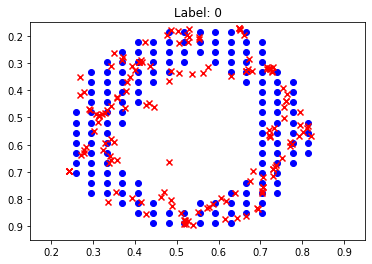

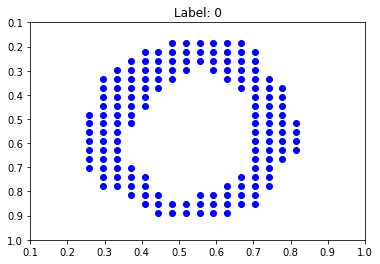

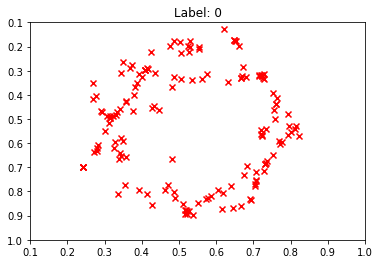

torch.Tensor

In [121]:
dataset = MNISTSet(train=False, full=True)
expected, sample,mask_sample = dataset[13]
x = sample[1, :]
y = sample[0, :]
pyplot.scatter(x, y,color ='b')

x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,marker = 'x',color ='r')

pyplot.axis([0.15, 0.95, 0.95, 0.15])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

x = sample[1, :]
y = sample[0, :]
pyplot.scatter(x, y,color ='b')
pyplot.axis([0.1, 1, 1, 0.1])
pyplot.title('Label: {}'.format(expected))

pyplot.show()
x = sam[1, :]
y = sam[0, :]
pyplot.scatter(x, y,marker = 'x',color ='r')
pyplot.axis([0.1, 1, 1, 0.1])
pyplot.title('Label: {}'.format(expected))
#plt.savefig('test.png')
pyplot.show()

sample = sample.unsqueeze(0)
mask_sample = mask_sample.unsqueeze(0)
expected = torch.tensor(expected).unsqueeze(0)
type(sample)